In [1]:
# 导入所需python库
from argparse import ArgumentParser
from datetime import datetime
import pickle
import sys, os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.abspath('/workspace/wangmq/Multimodal-Protein-Representation'))
#pd.set_option('display.max_colwidth', None)
from models import DomainEmbeddingModel

/opt/conda/envs/ESM-GearNet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
root = "/workspace/wangmq/Multimodal-Protein-Representation/data/swiss-prot"
#domain_map_file = os.path.join(root, 'domain_mapper_768.p')
#go_map_file = os.path.join(root, 'go_mapper_768.p')
domain_map_file = os.path.join(root, 'domain_mapper.p')
go_map_file = os.path.join(root, 'go_mapper.p')

with open(domain_map_file, 'rb') as f:
    domain_mapper = pickle.load(f)
with open(go_map_file, 'rb') as f:
    go_mapper = pickle.load(f)

model = DomainEmbeddingModel(num_domains=len(domain_mapper), num_goterms=len(go_mapper), emb_dim=768)
#model_path = '/workspace/wangmq/experiments/Mul-Pro/IntGoDataset/swiss_prot_dom2emb_768-20240328-T15-48/model_ep091.pt'
#model_path = '/workspace/wangmq/experiments/Mul-Pro/IntGoDataset/dom2emb_1280-20240418-T11-01/model_ep099.pt'
model_path = '/workspace/wangmq/experiments/Mul-Pro/IntGoDataset/swiss_prot_domemb-20240509-T11-20/model_ep476.pt'
model.load_state_dict(torch.load(model_path))
model.eval()

DomainEmbeddingModel(
  (embedding_domain): Embedding(31929, 768, max_norm=1)
  (embedding_go): Embedding(28944, 768, max_norm=1)
  (predict_head): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.05, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
  (project): Projector(
    (net1): Sequential(
      (0): Linear(in_features=768, out_features=1536, bias=True)
      (1): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (net2): Sequential(
      (0): Linear(in_features=1536, out_features=768, bias=True)
      (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)

In [32]:
root = "/workspace/wangmq/Multimodal-Protein-Representation/data/swiss-prot"
p_go_domain_file = os.path.join(root, 'p_go_domain_withneg_768.tsv')
#p_go_domain_file = os.path.join(root, 'p_go_domain_withneg.tsv')
#p_go_domain_file = os.path.join(root, 'p_go_domain_withneg_dombalance.tsv')

# Load the interpro2go file.
df_p_domain_go = pd.read_csv(p_go_domain_file, sep='\t', header=0)

In [33]:
df_p_domain_go

,domain,goterm,p_go_domain
0,IPR000001,GO:0000278,0.010417
1,IPR000001,GO:0000902,0.052083
2,IPR000001,GO:0001501,0.010417
3,IPR000001,GO:0001502,0.010417
4,IPR000001,GO:0001525,0.020833
...,...,...,...
4642752,IPR005862,GO:0038066,0.000000
4642753,IPR005862,GO:0070787,0.000000
4642754,IPR005862,GO:0001923,0.000000
4642755,IPR005862,GO:0005604,0.000000


In [34]:
domain_set = set(df_p_domain_go.domain)
len(domain_set)

31929

In [49]:
from random import sample

go_list = ['GO:0005737', 'GO:0005829', 'GO:0005886', 'GO:0005634', 'GO:0016020', 'GO:0046872']
index = 0
goterm = go_list[index]

if index==0:
    a = df_p_domain_go.loc[df_p_domain_go['goterm']=='GO:0005737'].sort_values('p_go_domain', ascending=False)
    a1 = a.loc[a['p_go_domain']>0.95].domain
    a2 = a.loc[a['p_go_domain']<0.1]
    a2 = a2.loc[a2['p_go_domain']>0].domain
elif index==1:
    a = df_p_domain_go.loc[df_p_domain_go['goterm']=='GO:0005829'].sort_values('p_go_domain', ascending=False)
    a1 = a.loc[a['p_go_domain']>0.5].domain
    a2 = a.loc[a['p_go_domain']<0.05]
    a2 = a2.loc[a2['p_go_domain']>0].domain
elif index==2:
    a = df_p_domain_go.loc[df_p_domain_go['goterm']=='GO:0005886'].sort_values('p_go_domain', ascending=False)
    a1 = a.loc[a['p_go_domain']>0.9].domain
    a2 = a.loc[a['p_go_domain']<0.1]
    a2 = a2.loc[a2['p_go_domain']>0].domain
elif index==3:
    a = df_p_domain_go.loc[df_p_domain_go['goterm']=='GO:0005634'].sort_values('p_go_domain', ascending=False)
    a1 = a.loc[a['p_go_domain']>0.9].domain
    a2 = a.loc[a['p_go_domain']<0.1]#.domain
    a2 = a2.loc[a2['p_go_domain']>0].domain
elif index==5: # metal ion binding
    a = df_p_domain_go.loc[df_p_domain_go['goterm']=='GO:0046872'].sort_values('p_go_domain', ascending=False)
    a1 = a.loc[a['p_go_domain']>0.9].domain
    a2 = a.loc[a['p_go_domain']<0.2]
    a2 = a2.loc[a2['p_go_domain']>0].domain
    

#a2 = domain_set - set(a.loc[a['p_go_domain'] > 0].domain)
#a2 = sample(a2, len(a1))

In [50]:
print(len(a1), len(a2))

3127 2783


In [51]:
domains = list(a1) + list(a2)
labels = [1] * len(a1) + [2] * len(a2)

In [52]:
print(len(domains), len(labels))

5910 5910


In [53]:
print("Computing Embeddings")
embeddings = []
for d in tqdm(domains):
    domain_id = domain_mapper[d]
    embeddings.append(model.get_domain_embedding(domain_id))

Computing Embeddings


100%|██████████| 5910/5910 [00:00<00:00, 25832.46it/s]


In [54]:
import numpy as np 
from sklearn.manifold import TSNE

def cal_tsne(x):
    x = np.array(x)
    print(f'Computing t-SNE embedding: size of {x.shape}')
    tsne = TSNE(n_components=2, init='pca', random_state=0)
    #tsne = TSNE(n_components=2, init='pca')
    #tsne = TSNE(perplexity=2000, n_components=2, init='pca', random_state=0)
    #tsne = TSNE(perplexity=50, n_components=2, init='pca', random_state=0, n_iter=1000, learning_rate=100)
    tsne.fit_transform(x)
    data = tsne.embedding_
    print(f'finish, size {data.shape}')
    return data

data = cal_tsne(embeddings)

Computing t-SNE embedding: size of (5910, 768)
finish, size (5910, 2)


In [55]:
# coding='utf-8'
import matplotlib.pyplot as plt
def plot_figure(data, labels):
    x_min, x_max = np.min(data, 0), np.max(data, 0) # 每一列元素的最大最小值
    data = (data - x_min) / (x_max - x_min) # 归一化
    
    fig = plt.figure()
    fig.patch.set_facecolor('white') #设置背景颜色
    fig.patch.set_alpha(1) #设置透明度
    ax = plt.gca()#获取边框
    #设置边框
    bwith = 2 #边框宽度设置为2
    ax.spines['bottom'].set_linewidth(bwith)#图框下边
    ax.spines['left'].set_linewidth(bwith)#图框左边
    ax.spines['top'].set_linewidth(bwith)#图框上边
    ax.spines['right'].set_linewidth(bwith)#图框右边
    #取消边框
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    
    ax = plt.subplot(111)
    for i in tqdm(range(data.shape[0])):
        #plt.text(data[i, 0], data[i, 1], str(labels[i]), color=plt.cm.Set1(labels[i] / 10.), fontdict={'weight': 'bold', 'size': 9})
        plt.scatter(data[i, 0], data[i, 1], color=plt.cm.Set1(labels[i] / 5.), marker='o', s=2, alpha=0.8)
    plt.xticks([])
    plt.yticks([])
    
    return fig

100%|██████████| 5910/5910 [00:40<00:00, 144.88it/s]


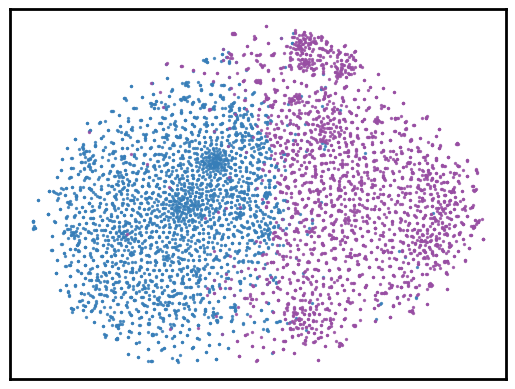

In [56]:
# coding='utf-8'
import matplotlib.pyplot as plt

fig = plot_figure(data, labels)
#plt.title(f"FAD {goterm}")
#plt.title(f"FAD")

plt.savefig(f'./test{index+1}.jpg')
plt.show(fig)

In [57]:
domains[0]

'IPR010304'

In [58]:
seq_emb_dir = "../data/swiss-prot/seq_embeddings/"
seq_emb_list = os.listdir(seq_emb_dir)
print(len(seq_emb_list))

33795


In [59]:
seq_embs = []
seq_labels = []
for i, dom in tqdm(enumerate(domains)):
    emb_path = os.path.join(seq_emb_dir, dom+'.pt')
    if not os.path.exists(emb_path):
        print(f"warning: {emb_path} not exist!")
        continue
    data = torch.load(emb_path)
    seq_embs.append(data['mean_representations'][33].numpy())
    seq_labels.append(labels[i])

427it [00:00, 4262.60it/s]

2919it [00:00, 4956.23it/s]

4430it [00:00, 4930.33it/s]

5910it [00:01, 4915.78it/s]

In [60]:
print(len(seq_embs), len(seq_labels))

5904 5904


In [61]:
data = cal_tsne(seq_embs)

Computing t-SNE embedding: size of (5904, 1280)
finish, size (5904, 2)


100%|██████████| 5904/5904 [00:41<00:00, 141.72it/s]


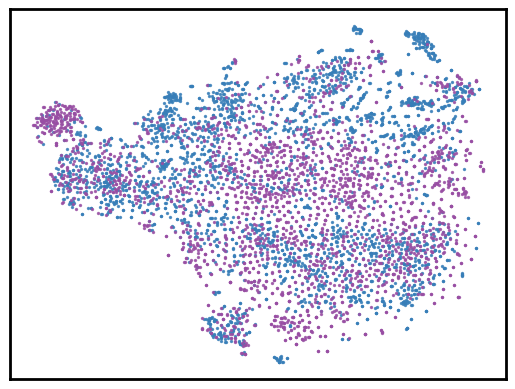

In [62]:
fig = plot_figure(data, seq_labels)
#plt.title(f"ESM-2 {goterm}")
#plt.title(f"ESM-2")

plt.savefig(f'./test{index+1}_seq.jpg')
plt.show(fig)

In [105]:
df_go_count = df_p_domain_go.loc[df_p_domain_go['p_go_domain']!=0].groupby(['goterm']).count().reset_index().sort_values('domain', ascending=False)
df_go_count.head(10)

,goterm,domain,p_go_domain
2907,GO:0005737,13726,13726
2977,GO:0005829,12529,12529
3019,GO:0005886,11064,11064
2848,GO:0005634,10605,10605
7073,GO:0016020,9225,9225
15901,GO:0046872,7103,7103
13656,GO:0042802,6666,6666
2857,GO:0005654,6630,6630
2810,GO:0005576,5412,5412
2908,GO:0005739,5363,5363


In [255]:
go_list = df_go_count['goterm'].values[:5]
go_list

array(['GO:0005737', 'GO:0005829', 'GO:0005886', 'GO:0005634',
       'GO:0016020'], dtype=object)

In [256]:
go_dict = {go:i+1 for i, go in enumerate(go_list)}

In [268]:
df_new = df_p_domain_go.loc[df_p_domain_go['goterm'].isin(go_list)]
df_new = df_new.loc[df_new['p_go_domain'] > 0.8]
df_new = df_new.loc[df_new['p_go_domain'] < 1.0].sort_values('domain')
df_new

,domain,goterm,p_go_domain
3689,IPR000023,GO:0005737,0.838356
3858,IPR000032,GO:0005737,0.914634
4662,IPR000037,GO:0005737,0.953911
4938,IPR000045,GO:0005886,0.942857
5063,IPR000047,GO:0005634,0.979508
...,...,...,...
1450053,IPR049381,GO:0005886,0.848315
1450075,IPR049383,GO:0005886,0.857955
1450610,IPR049400,GO:0005886,0.833333
1451105,IPR049428,GO:0005737,0.991085


In [269]:
domains = []
goterms = []
for d in tqdm(set(df_new['domain'])):
    df_s = df_new.loc[df_new['domain']==d].sort_values('p_go_domain', ascending=False)
    domains.append(d)
    goterms.append(df_s['goterm'].values[0])

100%|██████████| 3048/3048 [00:02<00:00, 1264.74it/s]


In [279]:
print("Computing Embeddings")
labels = []
embeddings = []
for i in tqdm(range(len(domains))):
    go_id = go_dict[goterms[i]]
    #if go_id > 2:
    #    continue
    if label_count[go_id-1] >= 1000:
        continue
    else:
        label_count[go_id-1] += 1
        
    domain_id = domain_mapper[domains[i]]
    embeddings.append(model.get_domain_embedding(domain_id))
    labels.append(go_id)

Computing Embeddings


100%|██████████| 3048/3048 [00:00<00:00, 44995.12it/s]
